# GDELT Demo: Classification

Instructions: [README.md](../README.md) in project root.

Starting point for Jupyter notebooks: [/Start_here.ipynb](../Start_here.ipynb) in project root.


This notebook breaks out some of the classification tasks associated with my GDELT analysis. For this initial stage I will address questions like: 


* Can I use various aggregate stats of "relationships" (as actor 1, actor 2, or both) to identify developed versus developing (or high- vs. low-GDP, or high- vs. low-HDI) countries?

## Findings and visualizations

**NOTE**: As with the regression analysis, to allow for execution of these demos without placing multiple gigabytes in the repo, I am engineering them to run with sample data when bigger datasets are unavailable. Thus specific metrics may not agree with what I report.

In [2]:
import sys
import os
import importlib

#project imports
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import classification
import pandas_gdelt_helper

Right now most of the interpretation is in the by-method sections below

**THIS NEEDS TO BE UPDATED A BIT**

### Classification by level of development

For this initial version, just divide the world into developed and developing countries based on GDP.
This classification isn't inherently earthshaking (because we can simply look up GDP and don't need GDELT to predict it) but it's a sort of sanity check that my classification strategies are interesting. More generally, predicting development by the 'signature' in GDELT might tell us something nontrivial about world events.

Features will be things like "number of different relationships," "ratio of actor 1 to actor 2 relationships," specific CAMEO codes (eventcode families) in those relationships, etc., where *relationships* means events linking actor 1 to actor 2.

In [1]:
importlib.reload(classification)
importlib.reload(pandas_gdelt_helper)
from pandas_gdelt_helper import PandasGdeltHelper
PandasGdeltHelper.country_features()


NameError: name 'importlib' is not defined

In [4]:
### Decision Tree

Gini score (minimal example) is 0.6896551724137931



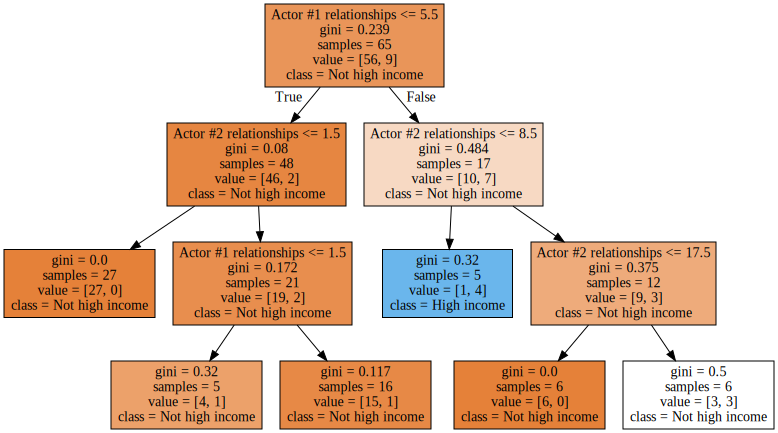

Gini score (enhanced example) is 0.7241379310344828



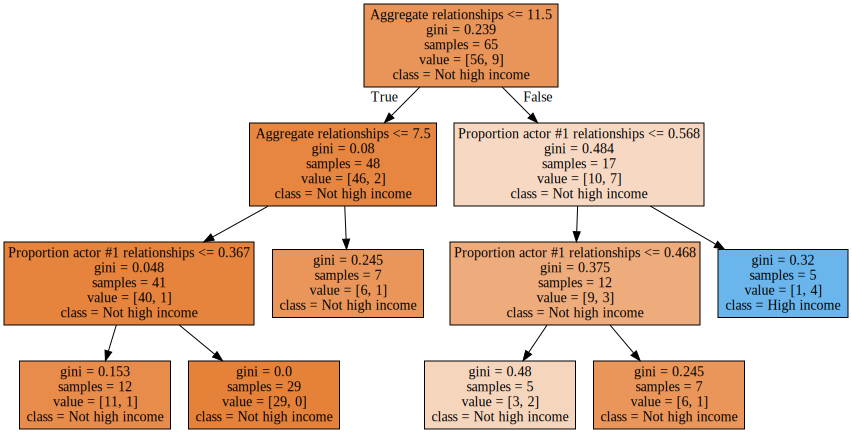

Entropy score (i.e. information gain) for minimal example is 0.6896551724137931

Entropy score (i.e. information gain) for enhanced example is 0.7241379310344828

Deeper tree Gini is 0.7241379310344828



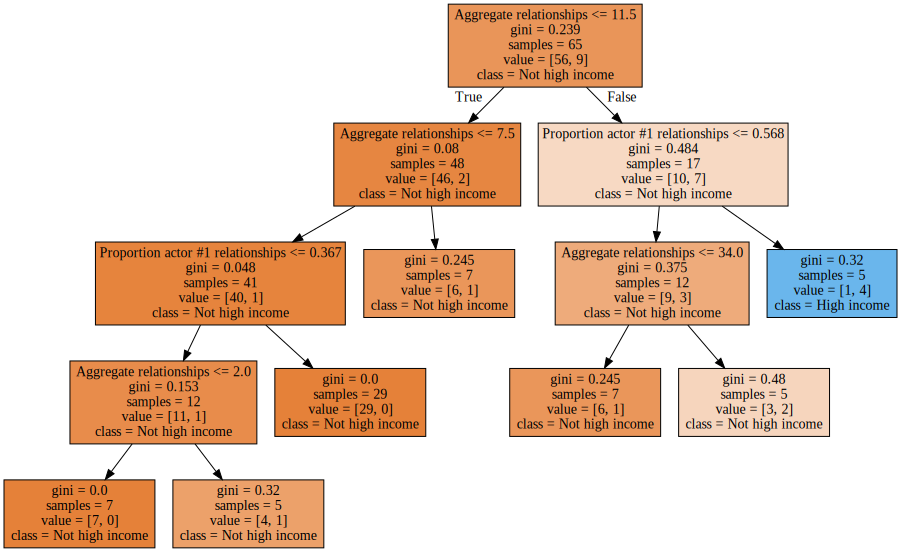

In [5]:
importlib.reload(classification)
importlib.reload(pandas_gdelt_helper)

from classification import GdeltDecisionTreeTask as DTTask
task = DTTask()
task.go()

#### Interpretation
This is mostly a proof of concept because running a 3-level decision tree with two features is pretty trivial. I will build it out with more features.

Nevertheless, the first one conforms more or less to my prior intuition:
* Less rich countries tend to be ''actors'' less often. There could be various reasons: the database may be biased toward actions by richer countries, or there may be a correlation between overall size (e.g. population) and wealth among these countries. 
* But among those who do have a lot of Actor \#1 relationships in the database, the wealthy ones tend to have fewer Actor \#2 relationships. They act upon others rather than being acted upon. Again, this could be bias in the dataset designations of actors 1 and 2, or could really be an underlying phenomenon.
* But then, among those countries with a large number of actor \#2 relationships (> 8.5) there are a few with an immense number of actor \#1 relationships (> 20). And those tend to be richer countries.

The second "enhanced" one performs less well by Gini score, and perhaps it contains a bit of a clue why. First, it's notable that the first decision is based on aggregate, and of those with total <= 11.5 the second decision is to further clarify it on aggregate. In other words on the left side proportion only figures in in the bottom left corner, because of one outlier country (Sweden with its three total relationships of which 1 is "actor 1").

But the proportion criterion on the right side seems to only be identifying the same 1,4 (although that's not certain) as the cell in the middle of the first tree. Intuitively it seems that the "enhanced" tree isn't adding any more information, and that proportion of actor 1 relationships MIGHT be a red herring. (We could also try this via regression or something else.)

It will be fun to watch this develop as I add a more reasonable number of features. Meanwhile here are some thoughts on how to build it out: 

* Add more features: Perhaps by type of event (violent vs nonviolent or aggressive etc.)
* And then on to the bigger goal -- time series related features.


But first, I want to try other classification methods.

In [6]:
importlib.reload(classification)
importlib.reload(pandas_gdelt_helper)

from classification import GdeltRandomForestTask as RFTask
task = RFTask()
task.go()


*****    RANDOM FOREST    *****
Feature importances:
actor1_relationships -- 0.27254683938778246
actor2_relationships -- 0.1903836567387359
aggregate_relationships -- 0.3015068310742926
proportion_actor1 -- 0.23556267279918902
Here are the random forest scores
[0.68085106 0.85106383]
predicted   0  1
actual          
0          22  1
1           6  0
Here is the classic random forest score: 0.7586206896551724
Decision path:(<94x210 sparse matrix of type '<class 'numpy.int64'>'
	with 4137 stored elements in Compressed Sparse Row format>, array([  0,  21,  42,  63,  78, 107, 126, 143, 164, 187, 210]))


### Using classifiers to predict violent events

The sanity check version of this would be whether simply a certain number of violent event codes at time *t-1* back to whatever *t-N* predicts violent events. Violent events will need to be defined based on CAMEO code.

More interestingly, the question would be predicting violence at time *t* through nonviolent patterns at time *t'* < *t*.